<a href="https://colab.research.google.com/github/TheSpaceMan915/Artificial-Intelligence/blob/main/Lab10_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа №10  Колычев Никита  ВПР34**

In [ ]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

# **Convolution using Sobel kernels**

# **Задание 1**

Из папки images загрузите изображение 'operator.png'. Выполните свёртку этого изображения с различными фильтрами, которые позволят сделать следующее:
*   Выделить только вертикальные границы
*   Выделить только горизонтальные границы
*   Выделить диагональные границы, идущие из северо-западного угла в юго-восточный.

Фильтры постройте самостотельно и поясните, почему использовали именно такие коэффициенты.

In [ ]:
# function to show an image
def show_image(map):
  fig, axes = plt.subplots(figsize=(8, 10))
  axes.axis("off")
  axes.imshow(np.absolute(map), cmap="gray")

# function to highlight contours  
def highlight_contours(map):
  map_highlighted = np.absolute(map) + 150
  map_highlighted[map_highlighted > 255] = 255
  return map_highlighted

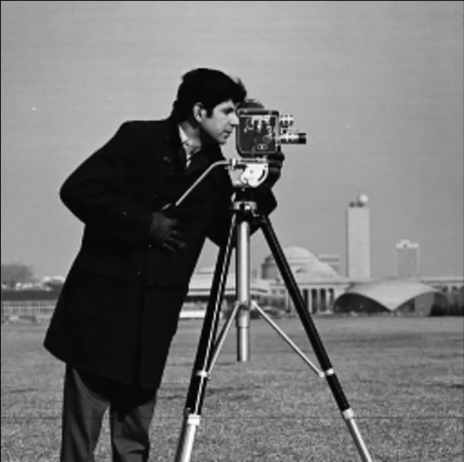

In [ ]:
# should use Sobel kernels
path_folder = "/content/drive/MyDrive/Colab Notebooks/AI/Lab10 pictures/"
img = Image.open(path_folder + "operator.png")
img_grey = img.convert("L")
display(img)

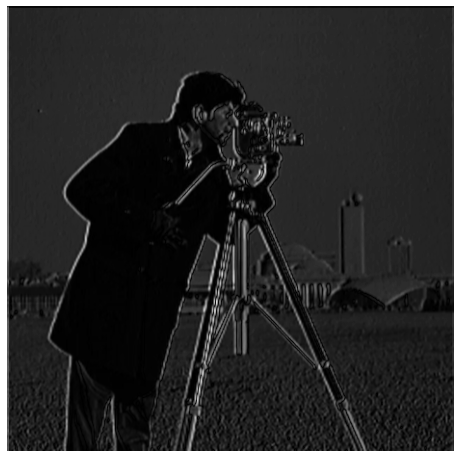

In [ ]:
# creating Horizontal Sobel kernel
arr_img = np.asarray(img_grey)
kernel_horizontal = np.array([[1, 0, -1],
                             [2, 0, -2],
                             [1, 0, -2]])

# convolving the image and highlighting vertical contours
map_features = signal.convolve2d(arr_img, kernel_horizontal, mode="same", boundary="symm")
show_image(map_features)

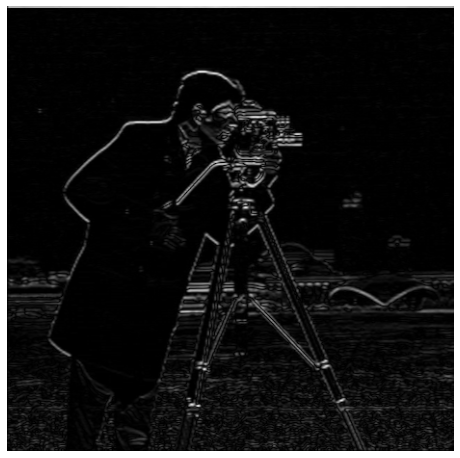

In [ ]:
# creating Vertical Sobel kernel
kernel_vertical = np.array([[-1, -2, -1],
                             [0, 0, 0],
                             [1, 2, 1]])

# convolving the image and highlighting vertical contours
map_features = signal.convolve2d(arr_img, kernel_vertical, mode="same", boundary="symm")
show_image(map_features)

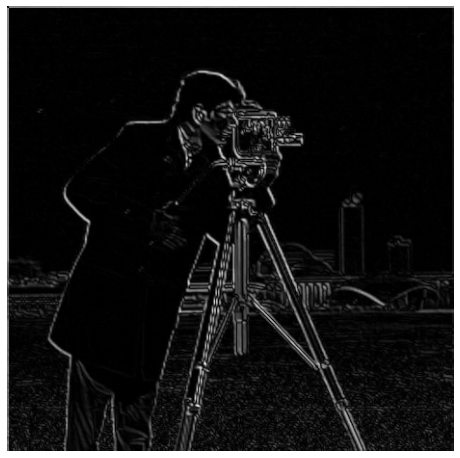

In [ ]:
# creating Diagonal Sobel kernel
kernel_diagonal = np.array([[0, 1, 2],
                            [-1, 0, 1],
                            [-2, -1, 0]])

# convolving the image and highlighting diagonal contours
map_features = signal.convolve2d(arr_img, kernel_diagonal, mode="same", boundary="symm")
show_image(map_features)

# **Задание 2**

Попробуйте несколько раз подряд выполнить свёртку изображения с фильтром размером 3х3, в котором все коэффициенты равны 1. Визуализируйте промежуточные результаты и объясните их.

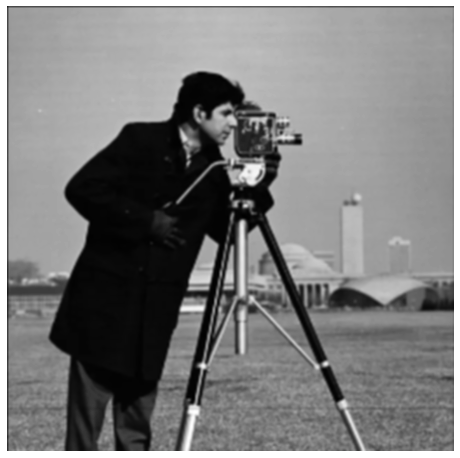

In [ ]:
# creating a kernel
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])

# convolving the image (the gets blurred more and more)
map_features_first = signal.convolve2d(arr_img, kernel, mode="same", boundary="symm")
show_image(map_features_first)

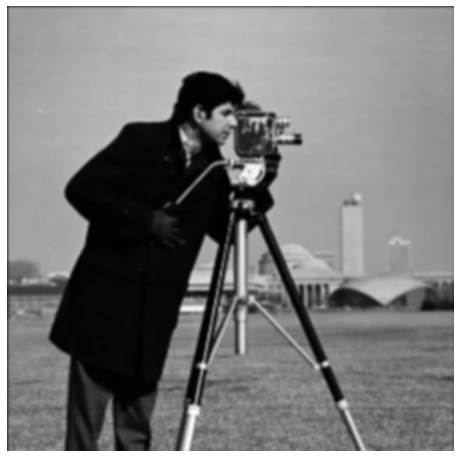

In [ ]:
map_features_second = signal.convolve2d(map_features_first, kernel, mode="same", boundary="symm")
show_image(map_features_second)

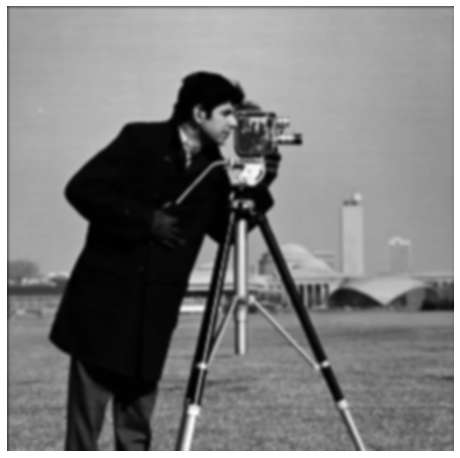

In [ ]:
map_features_third = signal.convolve2d(map_features_second, kernel, mode="same", boundary="symm")
show_image(map_features_third)

# **Convolutional neural network**

# **Задание 3**

Считаем построенную модель базовой (baseline). Теперь давайте улучшим её и выжмем столько точности, сколько получится.

1. Усовершенствуйте данную модель, добавив слой батч-нормализации. Оцените изменение результата.
2. Увеличьте размеры карт активации модели в несколько раз. Переобучите модель. Оцените изменение результата. Что можно сказать о такой модели, судя из кривых обучения?
3. Увеличьте глубину модели и переобучите её. Оцените изменение результата.

Найдите модель, которая устойчиво даёт точность классификации более 99% и при этом не является слишком большой.

In [ ]:
# creating a model
def create_model():
  model = Sequential([
  Conv2D(32, (3, 3), input_shape=(28, 28, 1), padding="same", activation="relu", kernel_initializer="he_uniform"),
  MaxPooling2D((2, 2), strides=2),
  BatchNormalization(),
  Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
  MaxPooling2D((2, 2), strides=2),
  BatchNormalization(),
  Flatten(),
  Dense(100, activation="relu", kernel_initializer="he_uniform"),
  Dropout(0.3),
  BatchNormalization(),
  Dense(100, activation="relu", kernel_initializer="he_uniform"),
  Dropout(0.3),
  BatchNormalization(),
  Dense(10, activation="softmax", kernel_initializer="glorot_uniform")
  ])

  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
# loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
    
# reshaping the sets so they have one colour channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# converting the labels to binary matrixes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

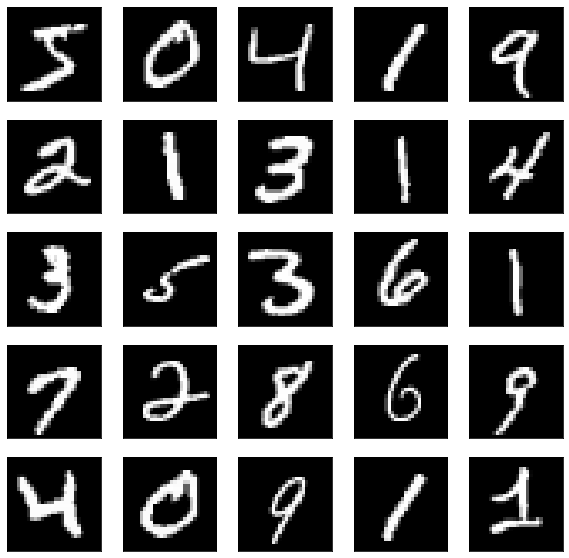

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.gray)

In [ ]:
# scaling the images
x_train_converted = x_train.astype("float32")
x_test_converted = x_test.astype("float32")

# setting up the brightness to the region of [0, 1]
x_train_converted = x_train_converted / 255.0
x_test_converted = x_test_converted / 255.0

In [ ]:
# creating a cross validator to control the fitting of the model
kfold = KFold(5, shuffle=True, random_state=1)
scores = []
histories = []

for train_ix, test_ix in kfold.split(x_train_converted):
  model = create_model()
  
  # splitting the data into several sets
  trainX, trainY, testX, testY = x_train_converted[train_ix], y_train[train_ix], x_train_converted[test_ix], y_train[test_ix]
  
  # fitting the model
  history = model.fit(trainX, trainY, epochs=15, batch_size=32, validation_data=(testX, testY), verbose=0)
  _, acc = model.evaluate(testX, testY, verbose=1)
  print('> %.3f' % (acc * 100.0))
  
  # saving the scores of the model
  scores.append(acc)
  histories.append(history)

375/375 [==============================] - 6s 17ms/step - loss: 0.0472 - accuracy: 0.9896
> 98.958
375/375 [==============================] - 7s 17ms/step - loss: 0.0375 - accuracy: 0.9902
> 99.025
375/375 [==============================] - 8s 20ms/step - loss: 0.0350 - accuracy: 0.9919
> 99.192
375/375 [==============================] - 8s 20ms/step - loss: 0.0257 - accuracy: 0.9936
> 99.358
375/375 [==============================] - 7s 18ms/step - loss: 0.0335 - accuracy: 0.9912
> 99.125


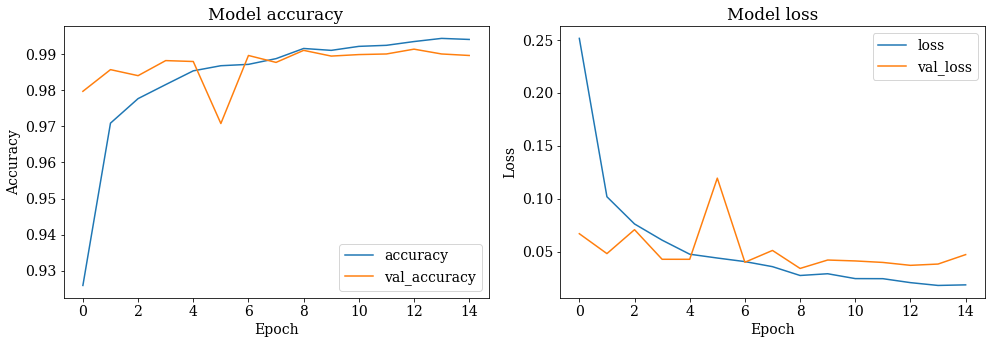

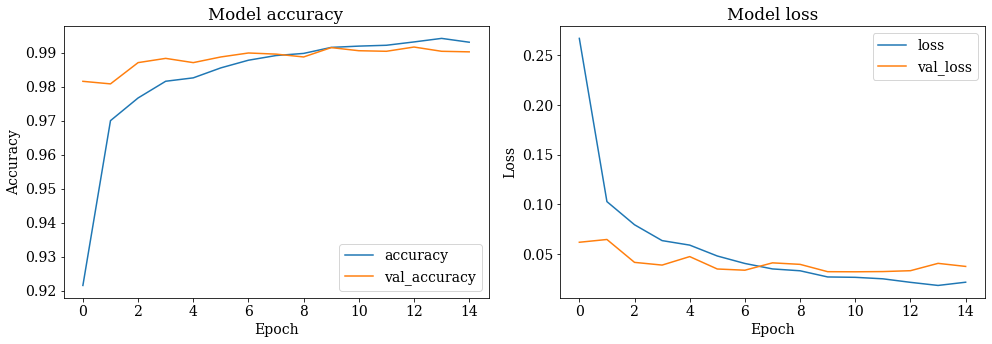

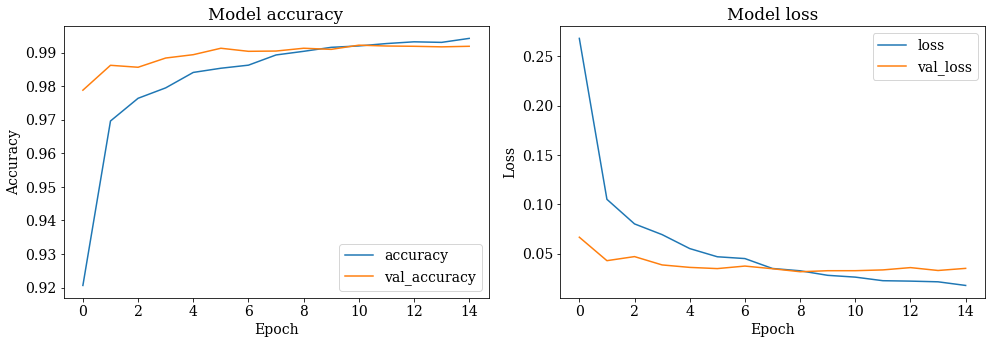

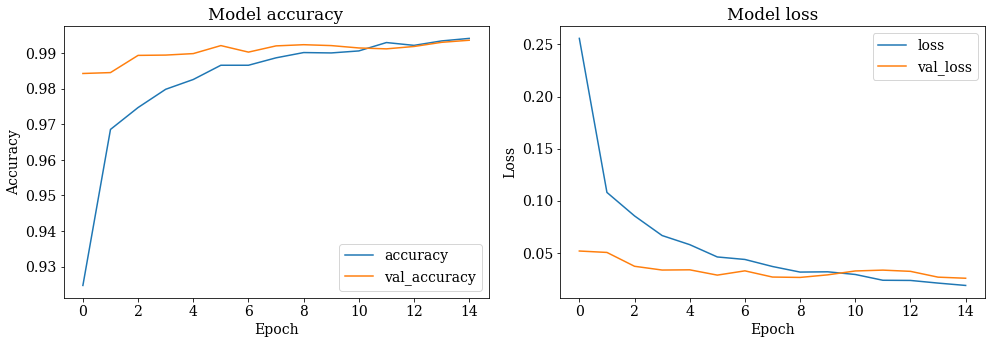

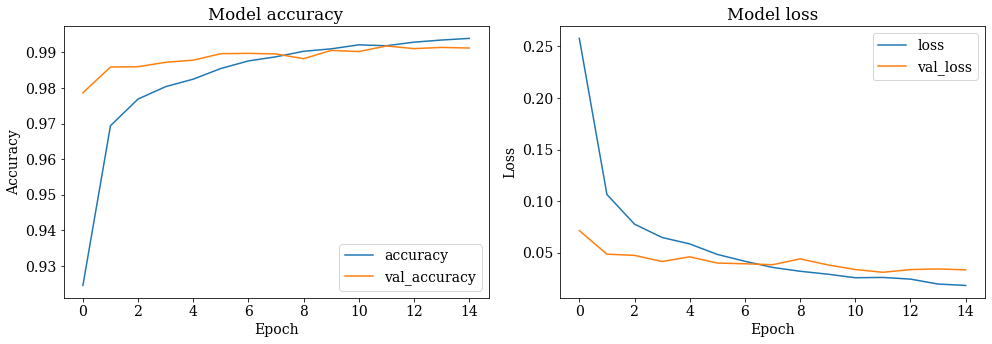

In [ ]:
for i in range(len(histories)):
  fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(14,5))
  plt.rcParams.update({"font.size": 14, "font.family": "serif"})
  
  axes1.plot(histories[i].history["accuracy"], label="accuracy")
  axes1.plot(histories[i].history["val_accuracy"], label="val_accuracy")
  axes1.set(title="Model accuracy")
  axes1.set(xlabel="Epoch")
  axes1.set(ylabel="Accuracy")
  axes1.legend(loc=4)

  axes2.plot(histories[i].history["loss"], label="loss")
  axes2.plot(histories[i].history["val_loss"], label="val_loss")
  axes2.set(title="Model loss")
  axes2.set(xlabel="Epoch")
  axes2.set(ylabel="Loss")
  axes2.legend(loc=1)
  fig.tight_layout()

Accuracy: mean=99.132 std=0.139, n=5


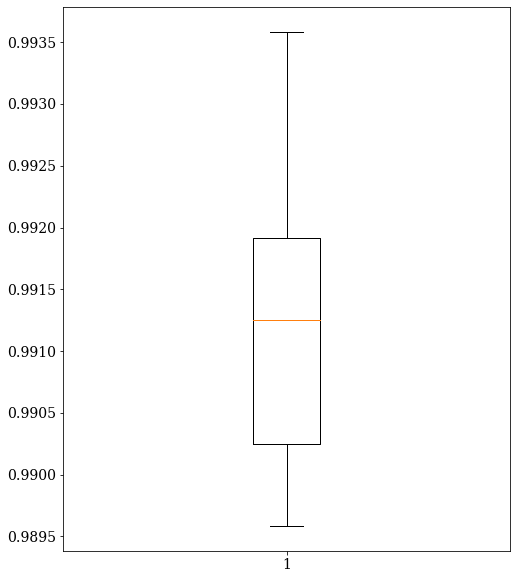

In [ ]:
# printing average scores
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))

# plotting a boxplot using the scores
plt.figure(figsize=(8, 10))
plt.boxplot(scores)
plt.show()